# Stochastic Geomodelling in Python using GemPy

### Import

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys, os
sys.path.append("../../../")
import gempy as gp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from gempy.utils import stochastic_surface as ss
from gempy.bayesian.posterior_analysis import calculate_probability_lithology, calculate_information_entropy
from gempy.assets import topology as tp
from tqdm import tqdm_notebook
import seaborn as sns

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


../../..\gempy\bayesian\posterior_analysis.py:24: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")
../../..\gempy\bayesian\posterior_analysis.py:28: UserWarning: pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.")


### Create the Geomodel

In [39]:
geo_model = gp.create_model('Demo')
extent = [0,2000.,0,2000.,0,2000.]
gp.init_data(geo_model, extent,[50,50,50], 
      path_o = "simple_fault_model_orientations.csv",
      path_i = "simple_fault_model_points.csv", default_values=True); #%%

gp.map_series_to_surfaces(geo_model,
                            {"Fault_Series":'Main_Fault', 
                             "Strat_Series": ('Sandstone_2','Siltstone',
                                              'Shale', 'Sandstone_1', 'basement')}, remove_unused_series=True);

geo_model.set_is_fault(['Fault_Series'])

groups = pickle.load(open("surf_pts_groups.p", "rb"))
geo_model.surface_points.df["group"] = groups
geo_model.orientations.df["group"] = None

Fault colors changed. If you do not like this behavior, set change_color to False.


## Visualizing the input data

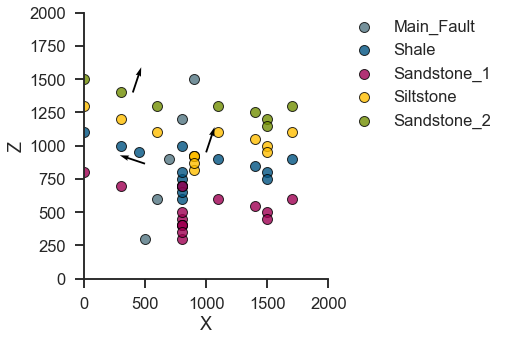

In [40]:
gp.plot.plot_data(geo_model)

In [44]:
gp.plot.plot_data_3D(geo_model);

closing vtk


In [43]:
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_compile',
    verbose=[]
)

Compiling theano function...
Compilation Done!


### Compute the Geomodel

In [45]:
sol = gp.compute_model(geo_model, compute_mesh=True)

### Plotting a section through the geomodel

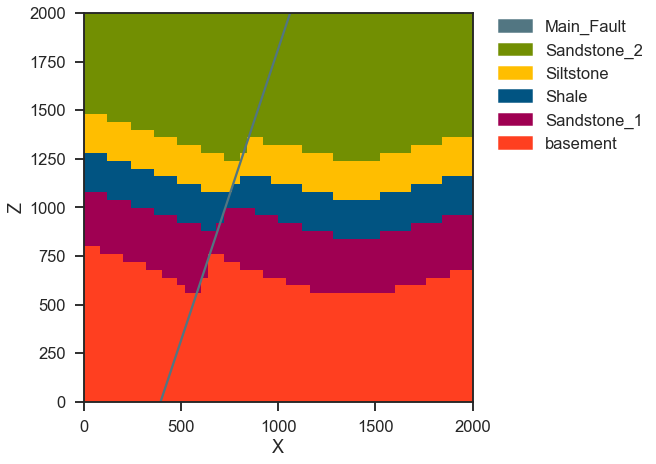

In [46]:
gp.plot.plot_section(geo_model, 24)

### Plotting the 3-D Geomodel 

In [48]:
gp.plot.plot_3D(geo_model, render_data=False)

closing vtk


In [49]:
from gempy.assets import topology as tp
graph_init, ctrs_init = tp.compute_topology(geo_model, 24, filter_rogue=True)

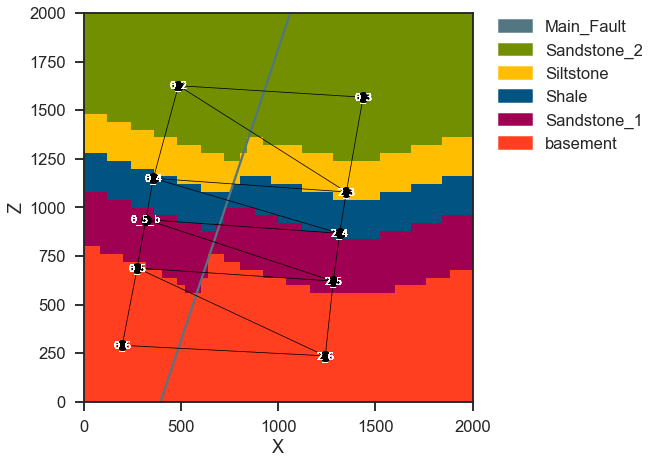

In [50]:
gp.plot.plot_section(geo_model, 24) 
gp.plot.plot_topology(geo_model, graph_init, ctrs_init)

### Modeling horizon and fault uncertainties

In [25]:
smod.reset()

#### Uncertainty parametrization

In [51]:
stochastic_surfaces = []
surface_names = np.unique(geo_model.surface_points.df.group)

for surface in surface_names:
    ssurf = ss.StochasticSurfaceScipy(geo_model, surface, grouping="group")
    
    if "Fault" in surface:
        ssurf.parametrize_surfpts_individual(50, direction="X")
    else:
        ssurf.parametrize_surfpts_single(30, direction="Z")
        
    stochastic_surfaces.append(ssurf)
    
smod = ss.StochasticModel(geo_model, stochastic_surfaces)

#### Uncertainty simulation

In [52]:
sols = []
graphs = []

for i in tqdm_notebook(range(10)):
    smod.sample()
    smod.modify()
    
    gp.compute_model(geo_model, compute_mesh=True)
    
    g, ctrs = tp.compute_topology(geo_model, 24, filter_rogue=True)
    if len(g.nodes) in [9, 10, 11]:
        sols.append(geo_model.solutions.block_matrix)
        graphs.append(g)
    
sols = np.array(sols)

### Visualizing Uncertainty

In [53]:
sols = np.load("sols.npy")

In [54]:
# grab the right data
lbs = sols[:, 1, 0, :].astype(int)
fbs = sols[:, 0, 0, :].astype(int)

# lithology probabilities
lb_probs = calculate_probability_lithology(lbs)
fb_probs = calculate_probability_lithology(fbs)
# information entropy
lb_ie = calculate_information_entropy(lb_probs)
fb_ie = calculate_information_entropy(fb_probs)

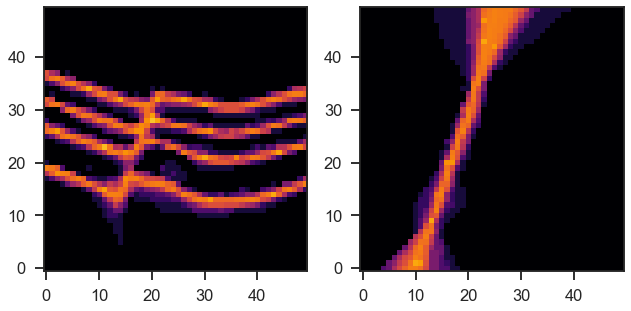

In [55]:
fig, axs = plt.subplots(ncols=2)

ies = [lb_ie, fb_ie]

vmin, vmax = np.min(ies), np.max(ies)
imkwargs = dict(origin="lower", cmap="inferno", vmin=vmin, vmax=vmax)

for ie, ax in zip(ies, axs):
    im = ax.imshow(ie.reshape(50, 50, 50)[:, 24, :].T, **imkwargs)

### Estimating reservoir volume uncertainty

In [56]:
def calc_vol(sols, n):
    """Calculate the volumes for a specified layer
    across all geomodels."""
    vols = []
    for sol in sols:
        lb = sol[1].astype(int)
        vol = np.count_nonzero(lb==n)
        vols.append(vol)
    return vols

Text(0.5, 1.0, 'Reservoir Volume Uncertainty')

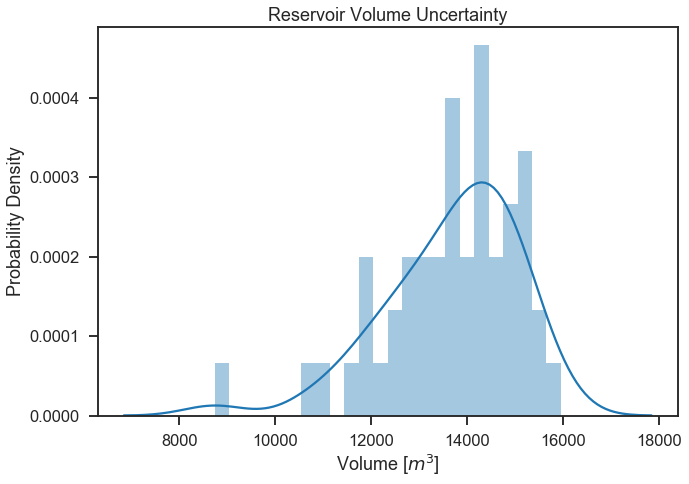

In [57]:
lb = sols[0][0].astype(int)
volumes = calc_vol(sols, 3)
ax = sns.distplot(volumes, bins=24)
ax.set_xlabel("Volume [$m^3$]")
ax.set_ylabel("Probability Density")
ax.set_title("Reservoir Volume Uncertainty")